In [1]:
# import
import os, sys
import numpy as np
import pandas as pd
import scipy as sp
import nibabel as nib
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend([r'/home/lindenmp/research_projects/nctpy/src'])

# import nctpy functions
from snaplab_tools.plotting.plotting import categorical_kde_plot, reg_plot, brain_scatter_plot, null_plot
from snaplab_tools.plotting.utils import get_my_colors, get_p_val_string
from snaplab_tools.prediction.regression import Regression
from snaplab_tools.utils import get_null_p

## Load data

In [2]:
# directory where data is stored
indir = '/home/lindenmp/research_projects/nct_xr/data/macaque'
outdir = '/home/lindenmp/research_projects/nct_xr/data'

In [3]:
macaque_A = nib.load(os.path.join(indir, "mean_macaque6_Conn3_log_Markov.pconn.nii"))
macaque_A = macaque_A.get_fdata()
print(macaque_A.shape)
print(np.all(np.round(macaque_A, 4) == np.round(macaque_A.T, 4)))

(182, 182)
True


In [4]:
macaque_A[np.eye(macaque_A.shape[0]) == 1] = 0

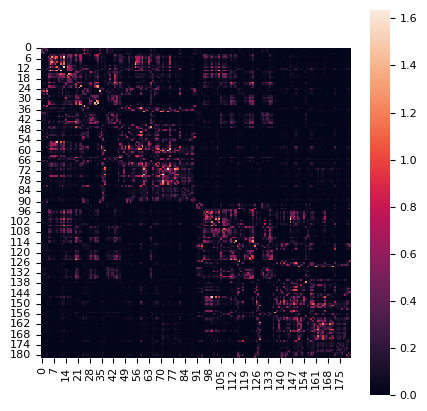

In [5]:
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(macaque_A, ax=ax, square=True)
plt.show()

In [6]:
np.count_nonzero(np.triu(macaque_A)) / ((macaque_A.shape[0] ** 2 - macaque_A.shape[0]) / 2)

0.9947787019610224

In [7]:
print(np.any(macaque_A < 0))
print(np.any(np.isinf(macaque_A)))
print(np.any(np.isnan(macaque_A)))

False
False
False


In [8]:
macaque_myelin = nib.load(os.path.join(indir, "MacaqueYerkes19_v1.2.MyelinMap_BC.32k_fs_LR_MarkovCC12_M132_182-area.32k_fs_LR.pscalar.nii"))
macaque_myelin = macaque_myelin.get_fdata()
macaque_myelin.shape

(1, 182)

In [9]:
macaque_ids = ['032125', '032132', '032134', '032136', '032139']

timeseries = np.zeros((250, 182, 1, len(macaque_ids)))

for i, macaque_id in enumerate(macaque_ids):
    ts = nib.load(os.path.join(indir, "032125_001_bold1_Atlas_Markov182.ptseries.nii"))
    ts = ts.get_fdata()
    print(ts.shape)

    gs = np.mean(ts, axis=1).reshape(-1, 1)
    gs_diff = np.append(0, np.diff(gs, axis=0)).reshape(-1, 1)
    nuis = np.concatenate((gs, gs_diff), axis=1)
    nuis = np.concatenate((nuis, np.square(nuis)), axis=1)
    regr = LinearRegression()
    regr.fit(nuis, ts)
    y_pred = regr.predict(nuis)
    ts = ts - y_pred
    
    # z score
    ts = sp.stats.zscore(ts, axis=0)
    
    timeseries[:, :, 0, i] = ts.copy()

(250, 182)
(250, 182)
(250, 182)
(250, 182)
(250, 182)


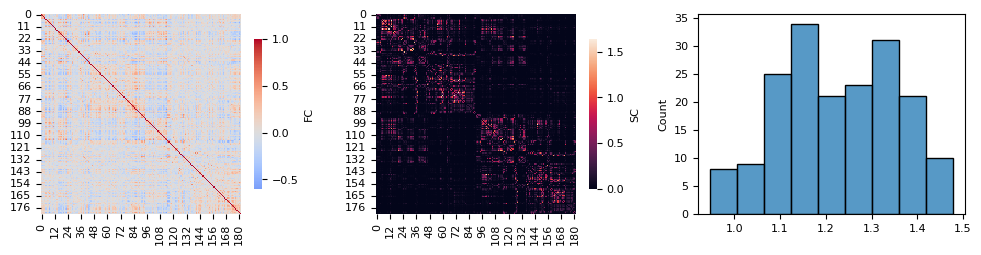

In [10]:
f, ax = plt.subplots(1, 3, figsize=(10, 2.5))
sns.heatmap(np.corrcoef(timeseries[:, :, 0, i].T), ax=ax[0], center=0, square=True, cmap='coolwarm', cbar_kws={'shrink': 0.75, 'label': 'FC'})
sns.heatmap(macaque_A, ax=ax[1], square=True, cmap='rocket', cbar_kws={'shrink': 0.75, 'label': 'SC'})
sns.histplot(macaque_myelin.flatten(), ax=ax[2])

# for this_ax in ax:
#     this_ax.set_xlabel('Region j')
#     this_ax.set_ylabel('Region i')

f.tight_layout()

## Save data

In [11]:
file_str = 'macaque_Markov_Am'
np.save(os.path.join(outdir, file_str), macaque_A)

file_str = 'macaque_Markov_rsts'
np.save(os.path.join(outdir, file_str), timeseries)

file_str = 'macaque_Markov_myelin'
np.save(os.path.join(outdir, file_str), macaque_myelin)
